# Projeto de Sinais

## Sinais e Sistemas Dinâmicos - Prof. Derzu Omaia

## Jansepetrus Brasileiro Pereira e Nathália de Vasconcelos Silva

Descrição do projeto: https://www.dropbox.com/s/wzibx7g7136um4z/Projeto.pdf?dl=0

## Importar todas as bibliotecas necessárias para o projeto

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.fftpack import fft
from scipy.signal import butter, lfilter, freqz
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings('ignore')

## Definição das funções de plot

In [ ]:
def plot_wav(wav, sample_rate, save_plot=False, nome_plot="", sufixo_nome=""):
    if(nome_plot == ""):
        from datetime import datetime
        nome_plot = str(datetime.now()).replace(":","-")
        
    times = np.arange(len(wav))/float(sample_rate)

    plt.figure(figsize=(30, 4))

    if(wav.ndim == 2):
        plt.fill_between(times, wav[:,0], wav[:,1], color='k') # para dual-channel
    else:
        plt.fill_between(times, wav)

    plt.xlim(times[0], times[-1])
    plt.xlabel('Tempo (s)')
    plt.ylabel('Amplitude')
    plt.title(sufixo_nome, loc='left')
    plt.title(nome_plot, loc='right')
    
    if(save_plot):
        plt.savefig(nome_plot + "_" + sufixo_nome + '.png', dpi=210)
    plt.show()

def plot_wav_freqDomain(fft_wav, freq, N, save_plot=False, nome_plot="", sufixo_nome=""):
    if(nome_plot == ""):
        from datetime import datetime
        nome_plot = str(datetime.now()).replace(":","-")
        
    plt.plot(freq, (1.0/N)*np.abs(fft_wav))
    plt.xlabel('Frequência (Hz)')
    plt.ylabel('Magnitude do Espectro (Domínio da Frequência)')
    plt.title(sufixo_nome, loc='left')
    plt.title(nome_plot, loc='right')
    plt.grid()
    if(save_plot):
        plt.savefig(nome_plot + "_" + sufixo_nome + '.png', dpi=210)
    plt.show()
    
def simple_plot_wav(wav_data, sample_rate, L, sufixo_nome="", save_plot=False, nome_plot=""):
    if(nome_plot == ""):
        from datetime import datetime
        nome_plot = str(datetime.now()).replace(":","-")

    plt.plot(np.arange(L) / sample_rate, wav_data)
    plt.xlim(0,L/sample_rate)
    plt.xlabel('Tempo (s)')
    plt.ylabel('Amplitude');
    plt.title(sufixo_nome, loc='left')
    plt.title(nome_plot, loc='right')
    
    if(save_plot):
        plt.savefig(nome_plot + "_" + sufixo_nome + '.png', dpi=210)
    plt.show()
    
def plot_resposta_freq(w, h, sample_rate, freq_corte, sufixo_nome="", save_plot=False, nome_plot=""):
    if(nome_plot == ""):
        from datetime import datetime
        nome_plot = str(datetime.now()).replace(":","-")
    
    #plt.subplot(2, 1, 1)
    plt.plot(0.5*sample_rate*w/np.pi, np.abs(h), 'b')
    plt.plot(freq_corte, 0.5*np.sqrt(2), 'ko')
    plt.axvline(freq_corte, color='k')
    plt.xlim(0, 0.5*sample_rate)
    plt.title("Resposta em Frequência - Filtro Passa-Baixa")
    plt.xlabel('Frequência (Hz)')
    plt.grid()
        
    if(save_plot):
        plt.savefig(nome_plot + "_" + sufixo_nome + '.png', dpi=210)
    
    plt.show()

## Definição dos parâmetros de execução

In [ ]:
####
# Parametros de Execucao
####
PLOT_SINAL_ORIGINAL = False
PLOT_SINAL_FFT = False
PLOT_SINAL_FFT_SHIFT = False
PLOT_SINAL_FFT_SHIFT_RESPFREQ = False
PLOT_SINAL_FFT_SHIFT_BUTTER = False
PLOT_SINAL_FFT_SHIFT_BUTTER_COMPARATIVO = False
PLOT_SINAL_FFT_SHIFT_BUTTER_CORTE = False
MONO = True
MONO_ESQ = True
STEREO = not MONO
MONO_DIR = not MONO_ESQ

## Tratamento do sinal

- Percorrer a pasta do dataset IRMAS
- Abrir todos os arquivos .wav
- Aplicar a transformada de Fourier 
- Transformada de Fourier deslocada 
- Filtro passa-baixa Butterworth
- Filtro passa-baixa
- Realizar um _crop_ 
- Salvar o sinal em um dataframe

In [ ]:
ROOT_PATH = 'TESTE' + os.sep

signal_dataset = []

for root, dirs, files in os.walk(ROOT_PATH):  
    for filename in files:

        ####
        # Leitura do arquivo WAV
        ####
        
        sample_rate, wav_data = wavfile.read(root + os.sep + filename)
        
        ####
        # Captura do sinal em um ndarray
        ####

        wav_data = np.mean(wav_data, axis=1) #Conversao de sinal stereo para mono, fazendo a media dos canais esquerdo e direito
        
        ####
        # Especificacoes do dominio do tempo
        ####
        
        L = wav_data.shape[0]
        dt = 1.0 / sample_rate
        t = np.arange(0, (L/sample_rate)-dt, dt).T # Discretizacao da amostragem ao passo ((L/sample_rate)-dt)
        #t = np.linspace(0, dt, L)
        N = t.size + 1
        if (PLOT_SINAL_ORIGINAL):
            #plot_wav(wav_data, sample_rate, sufixo_nome="ORIG", save_plot=True, nome_plot=filename)
            simple_plot_wav(wav_data, sample_rate, L, sufixo_nome="_01_ORIG", save_plot=True, nome_plot=filename)
        
        ####
        # Especificacoes do dominio da frequencia
        ####
        
        dF = sample_rate/N # hertz
        freq = np.arange(-sample_rate/2, sample_rate/2-dF, dF)
        freq_max = np.amax(freq)
        
        ####
        # Aplicacao da FFT e Calculo da Frequencia do sinal
        ####
        
        fft_output = fft(wav_data) # Fourier.
        if (PLOT_SINAL_FFT):
            plot_wav_freqDomain(fft_output, freq, N, sufixo_nome="_02_FFT", save_plot=True, nome_plot=filename)

        ####
        # Movimentacao dos componentes de frequencia zero para o centro do espectro
        ####
        
        fft_shifted = np.fft.fftshift( fft_output ) # Desloca o centro zero da transformada para o centro.
        #freq_shifted = np.fft.fftshift(freq)
        
        if (PLOT_SINAL_FFT_SHIFT):
            plot_wav_freqDomain(fft_shifted, freq, N, sufixo_nome="_03_FFT-SHIFT", save_plot=True, nome_plot=filename)

        ####
        # Aplicacao do Filtro Passa-Baixa Butterworth
        ####
        
        butter_order = 6
        freq_corte = freq_max*0.3 # TODO: Precisa descobrir se essa e' uma boa frequencia de corte para utilizar no Passa-Baixa Butterworth
        butter_cutoff = freq_corte / (0.5 * sample_rate)
        
        b, a = butter(butter_order, butter_cutoff, btype='low', analog=False)
    
        w, h = freqz(b, a, worN=8000)
        
        if(PLOT_SINAL_FFT_SHIFT_RESPFREQ):
            plot_resposta_freq(w, h, sample_rate, freq_corte, sufixo_nome="_04_FFT-SHIFT-RESPFREQ", save_plot=True, nome_plot=filename)
        
        fft_X_filtro = lfilter(b, a, fft_shifted)
        
        if(PLOT_SINAL_FFT_SHIFT_BUTTER):
            plot_wav_freqDomain(fft_X_filtro, freq, N, sufixo_nome="_05_FFT-SHIFT-FILT", save_plot=True, nome_plot=filename)
        
        if(PLOT_SINAL_FFT_SHIFT_BUTTER_COMPARATIVO):
            plt.plot(freq, fft_shifted.real, 'b-', label='data')
            plt.plot(freq, fft_X_filtro.real, 'g-', linewidth=2, label='filtered data')
            plt.title("_06_FFT-SHIFT-BUTTER-COMPARATIVO", loc='left')
            plt.title(filename, loc='right')
            plt.xlabel('Time [sec]')
            plt.grid()
            plt.legend()
            plt.savefig(filename + "_" + "_06_FFT-SHIFT-BUTTER-COMPARATIVO" + '.png', dpi=210)
            plt.show()
        
        centro_espectro = (fft_X_filtro.shape[0])//2
        offset = int((fft_X_filtro.shape[0]) * 0.05) # 5% de offset a partir do centro do espectro
        
        fft_filtro_corte = fft_X_filtro[centro_espectro-offset:centro_espectro+offset,]
        freq_dataframe = freq[centro_espectro-offset:centro_espectro+offset,]

        if(PLOT_SINAL_FFT_SHIFT_BUTTER_CORTE):
            plot_wav_freqDomain(fft_filtro_corte, freq_dataframe, N, sufixo_nome="_07_FFT-CORTE", save_plot=True, nome_plot=filename)
         
        ####
        # Adicao do sinal filtrado ao DataSet, para ser transformado em um DataFrame.
        ####
        
        signal_dataset.append(fft_filtro_corte)

df_data = pd.DataFrame(signal_dataset)
DATAFRAME_NAME = 'DEFINIR_NOME.pkl'
df_data.to_pickle(DATAFRAME_NAME)

## Ler um DataFrame salvo na máquina

In [2]:
DATAFRAME_NAME = 'T003_WAV_DF_INST100_20pc_nFILT.pkl'
data_frame = pd.read_pickle(DATAFRAME_NAME)

## Especificar o tipo do instrumento das instâncias

### Para 1 instância de cada instrumento

data_frame = data_frame.assign(instrument = '')

data_frame.iloc[0:1, 52918] = 'cel'
data_frame.iloc[1:2, 52918] = 'cla'
data_frame.iloc[2:3, 52918] = 'flu'
data_frame.iloc[3:4, 52918] = 'gac'
data_frame.iloc[4:5, 52918] = 'gel'
data_frame.iloc[5:6, 52918] = 'org'
data_frame.iloc[6:7, 52918] = 'pia'
data_frame.iloc[7:8, 52918] = 'sax'
data_frame.iloc[8:9, 52918] = 'tru'
data_frame.iloc[9:10, 52918] = 'vio'

### Para 5 instâncias de cada instrumento

data_frame = data_frame.assign(instrument = '')

data_frame.iloc[0:5, 13228] = 'cel'
data_frame.iloc[5:10, 13228] = 'cla'
data_frame.iloc[10:15, 13228] = 'flu'
data_frame.iloc[15:20, 13228] = 'gac'
data_frame.iloc[20:25, 13228] = 'gel'
data_frame.iloc[25:30, 13228] = 'org'
data_frame.iloc[30:35, 13228] = 'pia'
data_frame.iloc[35:40, 13228] = 'sax'
data_frame.iloc[40:45, 13228] = 'tru'
data_frame.iloc[45:50, 13228] = 'vio'

### Para 20 instâncias de cada instrumento

data_frame = data_frame.assign(instrument = '')

data_frame.iloc[0:20, 52918] = 'cel'
data_frame.iloc[20:40, 52918] = 'cla'
data_frame.iloc[40:60, 52918] = 'flu'
data_frame.iloc[60:80, 52918] = 'gac'
data_frame.iloc[80:100, 52918] = 'gel'
data_frame.iloc[100:120, 52918] = 'org'
data_frame.iloc[120:140, 52918] = 'pia'
data_frame.iloc[140:160, 52918] = 'sax'
data_frame.iloc[160:180, 52918] = 'tru'
data_frame.iloc[180:200, 52918] = 'vio'

### Para 100 instâncias de cada instrumento

In [3]:
data_frame = data_frame.assign(instrument = '')

data_frame.iloc[0:100, 52918] = 'cel'
data_frame.iloc[100:200, 52918] = 'cla'
data_frame.iloc[200:300, 52918] = 'flu'
data_frame.iloc[300:400, 52918] = 'gac'
data_frame.iloc[400:500, 52918] = 'gel'
data_frame.iloc[500:600, 52918] = 'org'
data_frame.iloc[600:700, 52918] = 'pia'
data_frame.iloc[700:800, 52918] = 'sax'
data_frame.iloc[800:900, 52918] = 'tru'
data_frame.iloc[900:1000, 52918] = 'vio'

## Usar o LabelEncoder na classe instrumento de todas as instâncias

Referência: http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html

In [4]:
instrument = data_frame.iloc[:, 52918].values
instrument = LabelEncoder().fit_transform(instrument)
data_frame['instrument'] = instrument

## Preparar variáveis para treino e teste geral

In [5]:
nX = data_frame.iloc[:, :-1].values
ny = data_frame.iloc[:, 52918].values

X_train, X_test, y_train, y_test = train_test_split(nX, ny, test_size = 0.1, random_state = 13)

## Usar o StandardScaler para alterar a escala dos dados para que o peso deles seja levado em consideração igualmente

Referência: http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

In [6]:
X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

## Executar o algoritmo K-NN para todas as instâncias do dataframe

- n_neighbors = 1    | Seguindo a especificação do trabalho para k = 1
- metric = minkowski | Métrica padrão da distância euclidiana
- p = 2              | Parâmetro da potência para a distância euclidiana

Referência: http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn-neighbors-kneighborsclassifier

In [7]:
classifier = KNeighborsClassifier(n_neighbors = 1, metric = 'minkowski', p = 2)
classifier.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')

## Predizer o resultado da aprendizagem de máquina geral

In [8]:
y_pred = classifier.predict(X_test)

## Acurácia geral

Referência: http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score

In [9]:
acc = accuracy_score(y_test, y_pred)
print(acc)

0.11


## Plot

([<matplotlib.axis.YTick at 0x7f5029f4b940>,
 <a list of 10 Text yticklabel objects>)

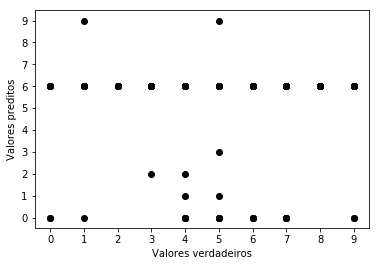

In [10]:
plt.scatter(y_test, y_pred, c = 'black')
plt.xlabel("Valores verdadeiros")
plt.xticks([0,1,2,3,4,5,6,7,8,9])
plt.ylabel("Valores preditos")
plt.yticks([0,1,2,3,4,5,6,7,8,9])

## Matriz de confusão

In [11]:
cnf = confusion_matrix(y_test, y_pred)
print(cnf)

[[2 0 0 0 0 0 6 0 0 0]
 [1 0 0 0 0 0 5 0 0 1]
 [0 0 0 0 0 0 6 0 0 0]
 [0 0 1 0 0 0 9 0 0 0]
 [4 1 1 0 0 0 7 0 0 0]
 [4 1 0 1 0 0 5 0 0 1]
 [3 0 0 0 0 0 9 0 0 0]
 [5 0 0 0 0 0 8 0 0 0]
 [0 0 0 0 0 0 9 0 0 0]
 [2 0 0 0 0 0 8 0 0 0]]


## Preparar variáveis para treino e teste do algoritmo de aprendizagem de máquina apenas para o violoncelo

In [12]:
cel_x = data_frame.iloc[0:100, :-1].values
cel_y = data_frame.iloc[0:100, 52918].values

X_train, X_test, y_train, y_test = train_test_split(cel_x, cel_y, test_size = 0.1, random_state = 13)

## Usar o StandardScaler para alterar a escala dos dados para que o peso deles seja levado em consideração igualmente

Referência: http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

In [13]:
X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

## Executar o algoritmo K-NN para as instâncias do "cello" no dataframe

- n_neighbors = 1    | Seguindo a especificação do trabalho para k = 1
- metric = minkowski | Métrica padrão da distância euclidiana
- p = 2              | Parâmetro da potência para a distância euclidiana

Referência: http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn-neighbors-kneighborsclassifier

In [14]:
classifier = KNeighborsClassifier(n_neighbors = 1, metric = 'minkowski', p = 2)
classifier.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')

## Predizer o resultado da aprendizagem de máquina para classificar o "cello"

In [15]:
y_pred = classifier.predict(X_test)

## Acurácia do "cello"

Referência: http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score

In [16]:
acc = accuracy_score(y_test, y_pred)
print(acc)

1.0


## Preparar variáveis para treino e teste do algoritmo de aprendizagem de máquina apenas para o clarinete

In [17]:
cla_x = data_frame.iloc[100:200, :-1].values
cla_y = data_frame.iloc[100:200, 52918].values

X_train, X_test, y_train, y_test = train_test_split(cla_x, cla_y, test_size = 0.1, random_state = 13)

## Usar o StandardScaler para alterar a escala dos dados para que o peso deles seja levado em consideração igualmente

Referência: http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

In [18]:
X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

## Executar o algoritmo K-NN para as instâncias do "cla" no dataframe

- n_neighbors = 1    | Seguindo a especificação do trabalho para k = 1
- metric = minkowski | Métrica padrão da distância euclidiana
- p = 2              | Parâmetro da potência para a distância euclidiana

Referência: http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn-neighbors-kneighborsclassifier

In [19]:
classifier = KNeighborsClassifier(n_neighbors = 1, metric = 'minkowski', p = 2)
classifier.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')

## Predizer o resultado da aprendizagem de máquina para classificar o "cla"

In [20]:
y_pred = classifier.predict(X_test)

## Acurácia do "cla"

Referência: http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score

In [21]:
acc = accuracy_score(y_test, y_pred)
print(acc)

1.0


## Preparar variáveis para treino e teste do algoritmo de aprendizagem de máquina apenas para a flauta

In [22]:
flu_x = data_frame.iloc[200:300, :-1].values
flu_y = data_frame.iloc[200:300, 52918].values

X_train, X_test, y_train, y_test = train_test_split(flu_x, flu_y, test_size = 0.1, random_state = 13)

## Usar o StandardScaler para alterar a escala dos dados para que o peso deles seja levado em consideração igualmente

Referência: http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

In [23]:
X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

## Executar o algoritmo K-NN para as instâncias do "flu" no dataframe

- n_neighbors = 1    | Seguindo a especificação do trabalho para k = 1
- metric = minkowski | Métrica padrão da distância euclidiana
- p = 2              | Parâmetro da potência para a distância euclidiana

Referência: http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn-neighbors-kneighborsclassifier

In [24]:
classifier = KNeighborsClassifier(n_neighbors = 1, metric = 'minkowski', p = 2)
classifier.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')

## Predizer o resultado da aprendizagem de máquina para classificar o "flu"

In [25]:
y_pred = classifier.predict(X_test)

## Acurácia do "flu"

Referência: http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score

In [26]:
acc = accuracy_score(y_test, y_pred)
print(acc)

1.0


## Preparar variáveis para treino e teste do algoritmo de aprendizagem de máquina apenas para a guitarra acústica

In [27]:
gac_x = data_frame.iloc[300:400, :-1].values
gac_y = data_frame.iloc[300:400, 52918].values

X_train, X_test, y_train, y_test = train_test_split(gac_x, gac_y, test_size = 0.1, random_state = 13)

## Usar o StandardScaler para alterar a escala dos dados para que o peso deles seja levado em consideração igualmente

Referência: http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

In [28]:
X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

## Executar o algoritmo K-NN para as instâncias do "gac" no dataframe

- n_neighbors = 1    | Seguindo a especificação do trabalho para k = 1
- metric = minkowski | Métrica padrão da distância euclidiana
- p = 2              | Parâmetro da potência para a distância euclidiana

Referência: http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn-neighbors-kneighborsclassifier

In [29]:
classifier = KNeighborsClassifier(n_neighbors = 1, metric = 'minkowski', p = 2)
classifier.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')

## Predizer o resultado da aprendizagem de máquina para classificar o "gac"

In [30]:
y_pred = classifier.predict(X_test)

## Acurácia do "gac"

Referência: http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score

In [31]:
acc = accuracy_score(y_test, y_pred)
print(acc)

1.0


## Preparar variáveis para treino e teste do algoritmo de aprendizagem de máquina apenas para a guitarra elétrica

In [32]:
gel_x = data_frame.iloc[400:500, :-1].values
gel_y = data_frame.iloc[400:500, 52918].values

X_train, X_test, y_train, y_test = train_test_split(gel_x, gel_y, test_size = 0.1, random_state = 13)

## Usar o StandardScaler para alterar a escala dos dados para que o peso deles seja levado em consideração igualmente

Referência: http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

In [33]:
X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

## Executar o algoritmo K-NN para as instâncias do "gel" no dataframe

- n_neighbors = 1    | Seguindo a especificação do trabalho para k = 1
- metric = minkowski | Métrica padrão da distância euclidiana
- p = 2              | Parâmetro da potência para a distância euclidiana

Referência: http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn-neighbors-kneighborsclassifier

In [34]:
classifier = KNeighborsClassifier(n_neighbors = 1, metric = 'minkowski', p = 2)
classifier.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')

## Predizer o resultado da aprendizagem de máquina para classificar o "gel"

In [35]:
y_pred = classifier.predict(X_test)

## Acurácia do "gel"

Referência: http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score

In [36]:
acc = accuracy_score(y_test, y_pred)
print(acc)

1.0


## Preparar variáveis para treino e teste do algoritmo de aprendizagem de máquina apenas para o órgão

In [37]:
org_x = data_frame.iloc[500:600, :-1].values
org_y = data_frame.iloc[500:600, 52918].values

X_train, X_test, y_train, y_test = train_test_split(org_x, org_y, test_size = 0.1, random_state = 13)

## Usar o StandardScaler para alterar a escala dos dados para que o peso deles seja levado em consideração igualmente

Referência: http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

In [38]:
X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

## Executar o algoritmo K-NN para as instâncias do "org" no dataframe

- n_neighbors = 1    | Seguindo a especificação do trabalho para k = 1
- metric = minkowski | Métrica padrão da distância euclidiana
- p = 2              | Parâmetro da potência para a distância euclidiana

Referência: http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn-neighbors-kneighborsclassifier

In [39]:
classifier = KNeighborsClassifier(n_neighbors = 1, metric = 'minkowski', p = 2)
classifier.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')

## Predizer o resultado da aprendizagem de máquina para classificar o "org"

In [40]:
y_pred = classifier.predict(X_test)

## Acurácia do "org"

Referência: http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score

In [41]:
acc = accuracy_score(y_test, y_pred)
print(acc)

1.0


## Preparar variáveis para treino e teste do algoritmo de aprendizagem de máquina apenas para o piano

In [42]:
pia_x = data_frame.iloc[600:700, :-1].values
pia_y = data_frame.iloc[600:700, 52918].values

X_train, X_test, y_train, y_test = train_test_split(pia_x, pia_y, test_size = 0.1, random_state = 13)

## Usar o StandardScaler para alterar a escala dos dados para que o peso deles seja levado em consideração igualmente

Referência: http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

In [43]:
X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

## Executar o algoritmo K-NN para as instâncias do "pia" no dataframe

- n_neighbors = 1    | Seguindo a especificação do trabalho para k = 1
- metric = minkowski | Métrica padrão da distância euclidiana
- p = 2              | Parâmetro da potência para a distância euclidiana

Referência: http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn-neighbors-kneighborsclassifier

In [44]:
classifier = KNeighborsClassifier(n_neighbors = 1, metric = 'minkowski', p = 2)
classifier.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')

## Predizer o resultado da aprendizagem de máquina para classificar o "pia"

In [45]:
y_pred = classifier.predict(X_test)

## Acurácia do "pia"

Referência: http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score

In [46]:
acc = accuracy_score(y_test, y_pred)
print(acc)

1.0


## Preparar variáveis para treino e teste do algoritmo de aprendizagem de máquina apenas para o saxofone

In [47]:
sax_x = data_frame.iloc[700:800, :-1].values
sax_y = data_frame.iloc[700:800, 52918].values

X_train, X_test, y_train, y_test = train_test_split(sax_x, sax_y, test_size = 0.1, random_state = 13)

## Usar o StandardScaler para alterar a escala dos dados para que o peso deles seja levado em consideração igualmente

Referência: http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

In [48]:
X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

## Executar o algoritmo K-NN para as instâncias do "sax" no dataframe

- n_neighbors = 1    | Seguindo a especificação do trabalho para k = 1
- metric = minkowski | Métrica padrão da distância euclidiana
- p = 2              | Parâmetro da potência para a distância euclidiana

Referência: http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn-neighbors-kneighborsclassifier

In [49]:
classifier = KNeighborsClassifier(n_neighbors = 1, metric = 'minkowski', p = 2)
classifier.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')

## Predizer o resultado da aprendizagem de máquina para classificar o "sax"

In [50]:
y_pred = classifier.predict(X_test)

## Acurácia do "sax"

Referência: http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score

In [51]:
acc = accuracy_score(y_test, y_pred)
print(acc)

1.0


## Preparar variáveis para treino e teste do algoritmo de aprendizagem de máquina apenas para o trumpete

In [52]:
tru_x = data_frame.iloc[800:900, :-1].values
tru_y = data_frame.iloc[800:900, 52918].values

X_train, X_test, y_train, y_test = train_test_split(tru_x, tru_y, test_size = 0.1, random_state = 13)

## Usar o StandardScaler para alterar a escala dos dados para que o peso deles seja levado em consideração igualmente

Referência: http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

In [53]:
X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

## Executar o algoritmo K-NN para as instâncias do "tru" no dataframe

- n_neighbors = 1    | Seguindo a especificação do trabalho para k = 1
- metric = minkowski | Métrica padrão da distância euclidiana
- p = 2              | Parâmetro da potência para a distância euclidiana

Referência: http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn-neighbors-kneighborsclassifier

In [54]:
classifier = KNeighborsClassifier(n_neighbors = 1, metric = 'minkowski', p = 2)
classifier.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')

## Predizer o resultado da aprendizagem de máquina para classificar o "tru"

In [55]:
y_pred = classifier.predict(X_test)

## Acurácia do "tru"

Referência: http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score

In [56]:
acc = accuracy_score(y_test, y_pred)
print(acc)

1.0


## Preparar variáveis para treino e teste do algoritmo de aprendizagem de máquina apenas para o violino

In [57]:
vio_x = data_frame.iloc[900:1000, :-1].values
vio_y = data_frame.iloc[900:1000, 52918].values

X_train, X_test, y_train, y_test = train_test_split(vio_x, vio_y, test_size = 0.1, random_state = 13)

## Usar o StandardScaler para alterar a escala dos dados para que o peso deles seja levado em consideração igualmente

Referência: http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

In [58]:
X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

## Executar o algoritmo K-NN para as instâncias do "vio" no dataframe

- n_neighbors = 1    | Seguindo a especificação do trabalho para k = 1
- metric = minkowski | Métrica padrão da distância euclidiana
- p = 2              | Parâmetro da potência para a distância euclidiana

Referência: http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn-neighbors-kneighborsclassifier

In [59]:
classifier = KNeighborsClassifier(n_neighbors = 1, metric = 'minkowski', p = 2)
classifier.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')

## Predizer o resultado da aprendizagem de máquina para classificar o "vio"

In [60]:
y_pred = classifier.predict(X_test)

## Acurácia do "vio"

Referência: http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score

In [61]:
acc = accuracy_score(y_test, y_pred)
print(acc)

1.0
